In [1]:
import pandas as pd
import time
import seaborn
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from sklearn import linear_model
import kernelml
import re

from ipyparallel import Client
rc = Client(profile='default')
dview = rc[:]

dview.block = True

with dview.sync_imports():
    import numpy as np
    from scipy import stats

importing numpy on engine(s)
importing stats from scipy on engine(s)


/Users/rohankotwani/anaconda/envs/datasci/lib/python3.5/site-packages/ipyparallel/client/client.py:442: RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@192.168.1.3')
            or instruct your controller to listen on an external IP.
  RuntimeWarning)


In [2]:
full = pd.read_csv('DATA/hb_training.csv')
test = pd.read_csv('DATA/hb_testing.csv')

def change_label(x):
    if x =='s':
        return 1
    else: 
        return 0
    
full['Label'] = full['Label'].apply(change_label)
EventId = test['EventId']
full.drop(['EventId'],axis=1,inplace=True)
test.drop(['EventId'],axis=1,inplace=True)
features = list(full.columns[:-2])
target = list(full.columns[-1:])

all_samples=full.index
ones = full[full[target].values==1].index
zeros = full[full[target].values==0].index
ones_rand_sample = np.random.choice(ones, size=int(len(ones)*0.5),replace=False)
zeros_rand_sample = np.random.choice(zeros, size=int(len(zeros)*0.5),replace=False)
rand_sample  = np.concatenate((ones_rand_sample,zeros_rand_sample))
np.random.shuffle(rand_sample)

test_sample = np.setdiff1d(all_samples,rand_sample)
valid = full.loc[test_sample,:]
train = full.loc[rand_sample,:]

In [3]:
class NNShapeHelper():

    def __init__(self,layer_shape,num_inputs,num_outputs):
        
        self.N_inputs = num_inputs
        self.N_outputs = num_outputs
        self.layer_shape = layer_shape
        self.N_layers = len(layer_shape)
        self.model_shape = []
        self.parameter_shape = []
        
    def get_N_parameters(self):
        
        self.model_shape.append(self.N_inputs)
        input_n_parameters = self.N_inputs*self.layer_shape[0]
        N =  input_n_parameters
        self.parameter_shape.append(input_n_parameters)
        
        for i in range(1,self.N_layers):
            layer_n_parameters = self.layer_shape[i-1]*self.layer_shape[i]
            self.model_shape.append(self.layer_shape[i])
            self.parameter_shape.append(layer_n_parameters)
            N += layer_n_parameters
            
        output_n_parameters = self.N_outputs*self.layer_shape[-1]
        N += output_n_parameters
        self.model_shape.append(self.N_outputs)
        self.parameter_shape.append(output_n_parameters)
        self.N_parameters = N
        return N

In [4]:
shapehelper = NNShapeHelper([10,len(features)],len(features),1)
num_parameters = shapehelper.get_N_parameters()
shapes = [shapehelper.model_shape,shapehelper.parameter_shape]
shapes

[[30, 30, 1], [300, 300, 30]]

In [5]:
def autoencoder_function(X,y,w_tensor,args,predict=False):
    from scipy import stats
    import numpy as np

    model_shape,parameter_shape,link = args
    # define the loss function between predicted output actual output
    def nn_autoencoder_loss(hypothesis,y):
        return np.sum((hypothesis-y)**2)/y.size

    def reshape_vector(w):
        reshape_w = []
        indx = 0
        for shape,num in zip(model_shape,parameter_shape):
            x = w[indx:num+indx]
            if x.size!=num:
                continue
            x = x.reshape(shape,int(num/shape))
            reshape_w.append(x)
            indx = indx+num
        extra_w = w[indx:]
        return reshape_w,extra_w
        
    #Specifies the way the tensors are combined with the inputs
    def combine_tensors(X,w_tensor,link):
        w_tensor,extra_w = reshape_vector(w_tensor)
        b1,a1,b2,a2 = extra_w[:4]
        pred = X.dot(w_tensor[0])
        if link == 'linear':
            pred = a1*(pred+b1)
        elif link == 'field_eq':
            pred = -0.5*a1*pred + b1*pred
        elif link == 'log':
            pred = a1*pred + np.log(np.abs(pred)+b1)
        elif link == 'inverse':
            pred = a1/(pred+b1)

        pred = pred.dot(w_tensor[1].T)
        pred = a2*(pred+b2)
        return pred

    #we cannot modify pickled memory so create a copy of the parameter vector
    w_tensor_copy = w_tensor.copy()
    pred = combine_tensors(X,w_tensor_copy,link)
    if predict==True:
        return pred
    loss = nn_autoencoder_loss(pred,y)
    return loss

In [9]:
X = train[features].values
y = train[target].values

#prior parameter sampler (default)
def prior_sampler_uniform_distribution(weights,num_param):
    return np.random.uniform(low=-1,high=1,size=(num_param,1000))

#sampler function (default)
def sampler_multivariate_normal_distribution(best_param,
                                            param_by_iter,
                                            error_by_iter,
                                            parameter_update_history,
                                            random_sample_num=100):
    covariance = np.diag(np.var(parameter_update_history[:,:],axis=1))
    best = param_by_iter[np.where(error_by_iter==np.min(error_by_iter))[0]]
    mean = best.flatten()
    try:
        return np.random.multivariate_normal(mean, covariance, (random_sample_num)).T
    except:
        print(best,np.where(error_by_iter==np.min(error_by_iter)))

#intermediate sampler
def intermediate_uniform_distribution(weights,num_param):
    result = []
    for i in range(num_param):
        x = np.random.uniform(weights[i]-0.1*weights[i],weights[i]+0.1*weights[i],size=(1,10000)).T
        result.append(x)
    result = np.squeeze(np.array(result))
    return result          

#parameter transform
def positive_int_transform(w):
    out = w.copy()
    extra_w = out[-4:]
    for i in range(extra_w.shape[0]):
        extra_w[i][np.where(extra_w[i]<=0)[0]]=1e-6
    out[-4:] = extra_w
    return out.reshape(w.shape)

runs=20
zscore = 2.0
umagnitude = 0.00001
analyzenparam = 100
nupdates = 1
npriorsamples=3600
nrandomsamples = 2400
tinterations = 5
sequpdate = False
link = 'field_eq'

kml = kernelml.KernelML(
         prior_sampler_fcn=None,
         sampler_fcn=None,
         intermediate_sampler_fcn=None,
         parameter_transform_fcn=positive_int_transform,
         batch_size=500)

kml.use_ipyparallel(dview)

parameter_by_run = kml.optimize(X,X,loss_function=autoencoder_function,
                                num_param=num_parameters+4,
                                args=shapes+[link],
                                runs=runs,
                                total_iterations=tinterations,
                                analyze_n_parameters=analyzenparam,
                                n_parameter_updates=nupdates,
                                update_magnitude=umagnitude,
                                sequential_update=sequpdate,
                                percent_of_params_updated=0.8,
                                init_random_sample_num=npriorsamples,
                                random_sample_num=nrandomsamples,
                                prior_uniform_low=-1,
                                prior_uniform_high=1,
                                convergence_z_score=1,
                                plot_feedback=False,
                                print_feedback=False)

('run', 0, 'loss', 74127.473644495651, 'time', 5.297924041748047)
('run', 1, 'loss', 50078.598234739242, 'time', 6.78652811050415)
('run', 2, 'loss', 39509.535970519275, 'time', 7.27153205871582)
('run', 3, 'loss', 28246.028423822569, 'time', 7.761844158172607)
('run', 4, 'loss', 20813.586045332457, 'time', 6.9654059410095215)
('run', 5, 'loss', 20011.956343675116, 'time', 6.292503118515015)
('run', 6, 'loss', 16187.0434892143, 'time', 7.679632902145386)
('run', 7, 'loss', 13276.427739302409, 'time', 6.465327024459839)
('run', 8, 'loss', 13606.149401214321, 'time', 7.927728891372681)
('run', 9, 'loss', 11464.873209093155, 'time', 7.522006988525391)
('run', 10, 'loss', 10167.015141196156, 'time', 7.31041693687439)
('run', 11, 'loss', 9712.0885036865202, 'time', 6.454974174499512)
('run', 12, 'loss', 8216.8781808712229, 'time', 6.970394849777222)
('run', 13, 'loss', 9273.3453231401418, 'time', 10.173343896865845)
('run', 14, 'loss', 8354.439366233717, 'time', 6.293745994567871)
('run', 1

In [11]:
X = train[features].values
y = train[target].values
X_test = valid[features].values
y_test = valid[target].values

autoencoder_SST_train = np.sum((X - np.mean(X,axis=0))**2)/X.size
autoencoder_SST_test = np.sum((X_test - np.mean(X,axis=0))**2)/X_test.size

#get model parameters of last run by interation
kml.model.get_param_by_iter()
kml.model.get_loss_by_iter()

print('performance by run')
for i in range(parameter_by_run.shape[0]):
    w=parameter_by_run[i].copy()
    autoencoder_SSE_train = autoencoder_function(X,X,w,shapes+[link])
    autoencoder_SSE_test = autoencoder_function(X_test,X_test,w,shapes+[link])
    print('iteration',i,'train rsquared',1-autoencoder_SSE_train/autoencoder_SST_train,'test rsquared',1-autoencoder_SSE_test/autoencoder_SST_test)

performance by run
iteration 0 train rsquared 0.180410618791 test rsquared 0.17804373913
iteration 1 train rsquared 0.442575202917 test rsquared 0.441883042778
iteration 2 train rsquared 0.576914430707 test rsquared 0.577318067865
iteration 3 train rsquared 0.687203870348 test rsquared 0.687219718117
iteration 4 train rsquared 0.755861512033 test rsquared 0.755825561273
iteration 5 train rsquared 0.782444293165 test rsquared 0.781962506948
iteration 6 train rsquared 0.80687445835 test rsquared 0.806645611277
iteration 7 train rsquared 0.837667248039 test rsquared 0.837267645517
iteration 8 train rsquared 0.853708626912 test rsquared 0.853180227232
iteration 9 train rsquared 0.872960231473 test rsquared 0.872410102747
iteration 10 train rsquared 0.882847399003 test rsquared 0.882314972285
iteration 11 train rsquared 0.891115458848 test rsquared 0.890754462165
iteration 12 train rsquared 0.899594302523 test rsquared 0.899149195401
iteration 13 train rsquared 0.904035964854 test rsquared 

In [80]:
X = train[features].values
y = train[target].values
X_test = valid[features].values
y_test = valid[target].values

autoencoder_SST_train = np.sum((X - np.mean(X,axis=0))**2)/X.size
autoencoder_SST_test = np.sum((X_test - np.mean(X,axis=0))**2)/X_test.size

def get_latent_encoding(X,w_tensor,link):
    w_tensor,extra_w = reshape_vector(w_tensor)
    b1,a1,b2,a2 = extra_w[:4]
    pred = X.dot(w_tensor[0])
    if link == 'linear':
        pred = a1*(pred+b1)
    elif link == 'field_eq':
        pred = -0.5*a1*pred + b1*pred
    elif link == 'log':
        pred = a1*np.log(np.abs(pred)+b1)
    elif link == 'inverse':
        pred = a1/(pred+b1)

    return pred

def reshape_vector(w):
    reshape_w = []
    indx = 0
    for shape,num in zip(shapes[0],shapes[1]):
        x = w[indx:num+indx]
        if x.size!=num:
            continue
        x = x.reshape(shape,int(num/shape))
        reshape_w.append(x)
        indx = indx+num
    extra_w = w[indx:]
    print('b1,a1,b2,a2',extra_w)
    return reshape_w,extra_w


#just for fun, we are going to use the latent variables in a predictive model
num_encodings = 5
encoding_dim = 10
X_prime = np.zeros((X.shape[0],num_encodings*encoding_dim))
X_test_prime = np.zeros((X_test.shape[0],num_encodings*encoding_dim))

#lets sample the last three iterations every 2 step (to avoid similarities)
start = 0
for i in np.arange(10,20,2):
    w=parameter_by_run[i].copy()
    X_prime[:,start:start+encoding_dim] = get_latent_encoding(X,w,link)
    X_test_prime[:,start:start+encoding_dim] = get_latent_encoding(X_test,w,link)
    start = start+encoding_dim

b1,a1,b2,a2 [  1.10137043e-02   6.65587925e-02   2.70340179e+01   2.28022189e-01]
b1,a1,b2,a2 [  1.10137043e-02   6.65587925e-02   2.70340179e+01   2.28022189e-01]
b1,a1,b2,a2 [  1.20476708e-02   5.99997320e-02   1.75996897e+01   2.57099810e-01]
b1,a1,b2,a2 [  1.20476708e-02   5.99997320e-02   1.75996897e+01   2.57099810e-01]
b1,a1,b2,a2 [  1.11272584e-02   5.87126935e-02   1.70730608e+01   2.35982711e-01]
b1,a1,b2,a2 [  1.11272584e-02   5.87126935e-02   1.70730608e+01   2.35982711e-01]
b1,a1,b2,a2 [ 0.01139576  0.05397906  0.82184919  0.26527898]
b1,a1,b2,a2 [ 0.01139576  0.05397906  0.82184919  0.26527898]
b1,a1,b2,a2 [  0.01227155   0.05629844  12.04195415   0.24423746]
b1,a1,b2,a2 [  0.01227155   0.05629844  12.04195415   0.24423746]


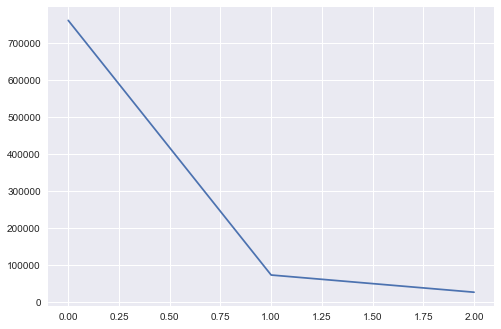

In [81]:
#lets combine the latent variables with PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(X_prime)
    
plt.plot(pca.explained_variance_)
plt.show()

X_prime = pca.transform(X_prime)
X_test_prime = pca.transform(X_test_prime)

In [82]:
#add the original variables to the features set
X_prime = np.column_stack((X,X_prime))
X_test_prime = np.column_stack((X_test,X_test_prime))

In [ ]:
from keras.layers import Input, Dense, Flatten
from keras.models import Model, Sequential

In [83]:
#model with latent variable PCA components
input_data = Input(shape=(X_prime.shape[1],))
layer1 = Dense(200, activation='sigmoid')(input_data)
layer2 = Dense(1, activation='sigmoid')(layer1)
model = Model(input_data, layer2)

model.compile(optimizer='adagrad', 
                    loss='binary_crossentropy')
model.fit(X_prime, y,
                epochs=100,
                batch_size=5000,
                shuffle=False,
                validation_data=(X_test_prime, y_test))


Train on 124999 samples, validate on 125001 samples
Epoch 1/100
124999/124999 [==============================] - 1s 9us/step - loss: 0.5872 - val_loss: 0.5561
Epoch 2/100
124999/124999 [==============================] - 0s 4us/step - loss: 0.5496 - val_loss: 0.5444
Epoch 3/100
124999/124999 [==============================] - 0s 4us/step - loss: 0.5391 - val_loss: 0.5386
Epoch 4/100
124999/124999 [==============================] - 0s 4us/step - loss: 0.5316 - val_loss: 0.5268
Epoch 5/100
124999/124999 [==============================] - 1s 5us/step - loss: 0.5224 - val_loss: 0.5212
Epoch 6/100
124999/124999 [==============================] - 1s 4us/step - loss: 0.5178 - val_loss: 0.5121
Epoch 7/100
124999/124999 [==============================] - 1s 5us/step - loss: 0.5108 - val_loss: 0.5078
Epoch 8/100
124999/124999 [==============================] - 0s 4us/step - loss: 0.5029 - val_loss: 0.5021
Epoch 9/100
124999/124999 [==============================] - 1s 4us/step - loss: 0.4960 - va

In [84]:
def get_acc(predict,y):
    return np.sum((predict>0.5).astype(np.int)==y)/len(y)
p_test = model.predict(X_test_prime)
p_train = model.predict(X_prime)
get_acc(p_test,y_test),get_acc(p_train,y)

(0.81844945240438072, 0.82194257554060435)

In [85]:
#model without latent variable PCA components
input_data = Input(shape=(X.shape[1],))
layer1 = Dense(200, activation='sigmoid')(input_data)
layer2 = Dense(1, activation='sigmoid')(layer1)
model = Model(input_data, layer2)

model.compile(optimizer='adagrad', 
                    loss='binary_crossentropy')
model.fit(X, y,
                epochs=100,
                batch_size=5000,
                shuffle=False,
                validation_data=(X_test, y_test))

Train on 124999 samples, validate on 125001 samples
Epoch 1/100
124999/124999 [==============================] - 1s 8us/step - loss: 0.6011 - val_loss: 0.5701
Epoch 2/100
124999/124999 [==============================] - 1s 4us/step - loss: 0.5650 - val_loss: 0.5585
Epoch 3/100
124999/124999 [==============================] - 1s 4us/step - loss: 0.5556 - val_loss: 0.5567
Epoch 4/100
124999/124999 [==============================] - 0s 4us/step - loss: 0.5505 - val_loss: 0.5445
Epoch 5/100
124999/124999 [==============================] - 1s 4us/step - loss: 0.5432 - val_loss: 0.5459
Epoch 6/100
124999/124999 [==============================] - 1s 4us/step - loss: 0.5416 - val_loss: 0.5397
Epoch 7/100
124999/124999 [==============================] - 1s 4us/step - loss: 0.5373 - val_loss: 0.5370
Epoch 8/100
124999/124999 [==============================] - 1s 4us/step - loss: 0.5336 - val_loss: 0.5314
Epoch 9/100
124999/124999 [==============================] - 1s 4us/step - loss: 0.5288 - va

In [86]:
def get_acc(predict,y):
    return np.sum((predict>0.5).astype(np.int)==y)/len(y)
p_test = model.predict(X_test)
p_train = model.predict(X)
get_acc(p_test,y_test),get_acc(p_train,y)

(0.79688162494700043, 0.80040640325122603)